In [17]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler 
from sklearn.cross_validation import train_test_split

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.datasets import mnist

import matplotlib.pyplot as plt

### Load data

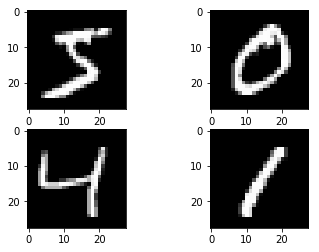

In [18]:
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [19]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Notice -- We need to reshape each image by flattening it into a 784 element vector.

In [20]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

In [21]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

In [22]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

### Create baseline model

The model is a simple neural network with one hidden layer with the same number of neurons as there are inputs (784). A rectifier activation function is used for the neurons in the hidden layer.

A softmax activation function is used on the output layer to turn the outputs into probability-like values and allow one class of the 10 to be selected as the model’s output prediction. Logarithmic loss is used as the loss function (called categorical_crossentropy in Keras) and the efficient ADAM gradient descent algorithm is used to learn the weights.

In [23]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=True)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s - loss: 0.2793 - acc: 0.9208 - val_loss: 0.1417 - val_acc: 0.9575
Epoch 2/10
60000/60000 [==============================] - 5s - loss: 0.1117 - acc: 0.9677 - val_loss: 0.0921 - val_acc: 0.9712
Epoch 3/10
60000/60000 [==============================] - 5s - loss: 0.0719 - acc: 0.9797 - val_loss: 0.0782 - val_acc: 0.9766
Epoch 4/10
60000/60000 [==============================] - 5s - loss: 0.0505 - acc: 0.9856 - val_loss: 0.0736 - val_acc: 0.9768
Epoch 5/10
60000/60000 [==============================] - 5s - loss: 0.0373 - acc: 0.9892 - val_loss: 0.0679 - val_acc: 0.9786
Epoch 6/10
60000/60000 [==============================] - 5s - loss: 0.0268 - acc: 0.9929 - val_loss: 0.0632 - val_acc: 0.9809
Epoch 7/10
60000/60000 [==============================] - 4s - loss: 0.0209 - acc: 0.9947 - val_loss: 0.0610 - val_acc: 0.9815
Epoch 8/10
60000/60000 [==============================] - 5s 

### Convoluted Neural Network

In [25]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [26]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Notice -- for the ConvNet, we need to reshape each image into a 28x28x1 pixel array. 

In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In the case of MNIST where the pixel values are gray scale, the pixel dimension is set to 1.

In [27]:
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [28]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

### Building the ConvNet

Convolutional neural networks are more complex than standard multi-layer perceptrons, so we will start by using a simple structure to begin with that uses all of the elements for state of the art results. Below summarizes the network architecture.

1. The first hidden layer is a convolutional layer called a Convolution2D. The layer has 32 feature maps, which with the size of 5×5 and a rectifier activation function. This is the input layer, expecting images with the structure outline above [pixels][width][height].
2. Next we define a pooling layer that takes the max called MaxPooling2D. It is configured with a pool size of 2×2.
3. The next layer is a regularization layer using dropout called Dropout. It is configured to randomly exclude 20% of neurons in the layer in order to reduce overfitting.
4. Next is a layer that converts the 2D matrix data to a vector called Flatten. It allows the output to be processed by standard fully connected layers.
5. Next a fully connected layer with 128 neurons and rectifier activation function.
6. Finally, the output layer has 10 neurons for the 10 classes and a softmax activation function to output probability-like predictions for each class.

As before, the model is trained using logarithmic loss and the ADAM gradient descent algorithm.

In [29]:
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [30]:
# build the model
model = cnn_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
85s - loss: 0.2340 - acc: 0.9342 - val_loss: 0.0817 - val_acc: 0.9744
Epoch 2/10
85s - loss: 0.0735 - acc: 0.9781 - val_loss: 0.0465 - val_acc: 0.9843
Epoch 3/10
85s - loss: 0.0532 - acc: 0.9839 - val_loss: 0.0439 - val_acc: 0.9858
Epoch 4/10
85s - loss: 0.0405 - acc: 0.9877 - val_loss: 0.0406 - val_acc: 0.9862
Epoch 5/10
85s - loss: 0.0338 - acc: 0.9891 - val_loss: 0.0345 - val_acc: 0.9884
Epoch 6/10
86s - loss: 0.0278 - acc: 0.9914 - val_loss: 0.0326 - val_acc: 0.9888
Epoch 7/10
85s - loss: 0.0236 - acc: 0.9927 - val_loss: 0.0363 - val_acc: 0.9882
Epoch 8/10
85s - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0319 - val_acc: 0.9890
Epoch 9/10
89s - loss: 0.0172 - acc: 0.9945 - val_loss: 0.0305 - val_acc: 0.9897
Epoch 10/10
90s - loss: 0.0145 - acc: 0.9957 - val_loss: 0.0328 - val_acc: 0.9903
Baseline Error: 0.97%


### Larger ConvNet

In [31]:
# Larger CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.

1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

In [34]:
# define the larger model
def large_cnn():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
# build the model
model = large_cnn()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 104s - loss: 0.3935 - acc: 0.8792 - val_loss: 0.0974 - val_acc: 0.9688
Epoch 2/10
60000/60000 [==============================] - 111s - loss: 0.0955 - acc: 0.9703 - val_loss: 0.0594 - val_acc: 0.9804
Epoch 3/10
60000/60000 [==============================] - 112s - loss: 0.0694 - acc: 0.9783 - val_loss: 0.0380 - val_acc: 0.9882
Epoch 4/10
60000/60000 [==============================] - 111s - loss: 0.0563 - acc: 0.9828 - val_loss: 0.0323 - val_acc: 0.9898
Epoch 5/10
60000/60000 [==============================] - 110s - loss: 0.0483 - acc: 0.9849 - val_loss: 0.0297 - val_acc: 0.9910
Epoch 6/10
60000/60000 [==============================] - 111s - loss: 0.0431 - acc: 0.9865 - val_loss: 0.0268 - val_acc: 0.9920
Epoch 7/10
60000/60000 [==============================] - 112s - loss: 0.0386 - acc: 0.9876 - val_loss: 0.0274 - val_acc: 0.9909
Epoch 8/10
60000/60000 [=======================